# Amazon fine food review - Sentiment analysis

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

In [196]:
odf = pd.read_csv('/Users/liuxuan/Desktop/未命名檔案夾 3/Xuan Liu Career/Data/NLP/Amazon Fine Food Review/Reviews.csv')
odf.shape

(568454, 10)

In [197]:
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1, 'How helpful users find among user scores')

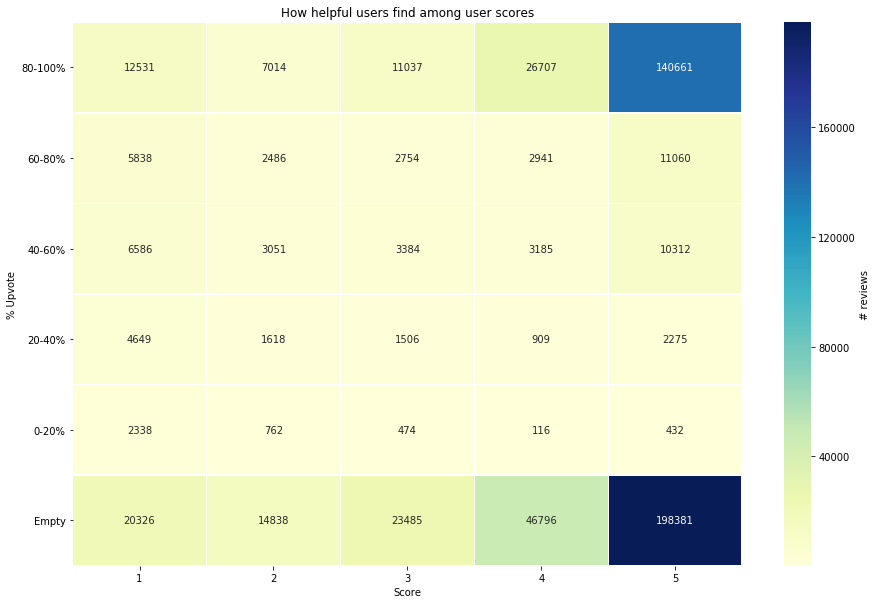

In [198]:
# Heatmap for count of Scores and 
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id':'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation = 0)
plt.title('How helpful users find among user scores')

### Set Binary Classification
###### Score: 
- 3 -- neutral
- 4, 5 -- positive = 1
- 1, 2 -- negative = 0

In [199]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

# Score Prediction

### Logistic regression model on word count

In [200]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model, clf_model, coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
        
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/Users/liuxuan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.9358254598566799

-Top 20 positive-
        Word  Coefficient
  pleasantly     4.231443
    downside     3.124807
   addicting     2.957420
    drawback     2.668842
   skeptical     2.509512
      resist     2.378750
  economical     2.264488
        whim     2.235129
    soothing     2.217814
     easiest     2.205680
      hooked     2.173000
     welcome     2.083365
   delighted     2.078078
       meets     1.975624
         yay     1.975078
   excellent     1.973635
 wonderfully     1.970140
     worries     1.944431
 exceptional     1.941295
      delish     1.932992

-Top 20 negative-
          Word  Coefficient
         ruins    -2.304709
        lacked    -2.326325
         blech    -2.333292
    unfinished    -2.348778
    unbearable    -2.354965
           ick    -2.418196
    overpowers    -2.487798
   unappealing    -2.530593
   disapointed    -2.556615
       defeats    -2.613164
    returnable    -2.683114
      mediocre    -2.734555
        ripoff   

Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficients are not meaningful, e.g. 280mg.

Let's also look at the base line accuracy (predicting with majority class, in this case positive class):

In [201]:
text_fit(X, y, c, DummyClassifier(), 0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.7373529903996835


/Users/liuxuan/anaconda3/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


### Logistic regression model on TFIDF

In [202]:
tfidf = TfidfVectorizer(stop_words = 'english')

In [203]:
tfidf_n = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/Users/liuxuan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.9347528412980967

-Top 20 positive-
       Word  Coefficient
      great    13.831629
  delicious    12.265532
       best    11.951571
    perfect    10.602589
  excellent     9.911412
      loves     9.589458
     highly     8.901068
       love     8.379898
  wonderful     8.015796
    amazing     7.610813
 pleasantly     7.506317
    awesome     7.376063
       good     7.331737
     hooked     7.142055
       nice     7.141081
   favorite     6.902051
    pleased     6.833578
     smooth     6.811130
      yummy     6.729469
  fantastic     6.523490

-Top 20 negative-
           Word  Coefficient
   unacceptable    -5.621543
           poor    -5.689610
           yuck    -5.886536
    undrinkable    -5.935193
          worse    -6.124222
          stale    -6.125399
          bland    -6.378044
     disgusting    -6.411951
           weak    -6.466841
          threw    -6.658686
      tasteless    -6.661740
         return    -6.752547
  unfortunately    -7.482

Accurancy is roughly the same - 93.5%. However we notice that the significant words make much more sense now, with higher coefficient magnitude as well!

### Logistic regression model on TFIDF + ngram

In [134]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/Users/liuxuan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.9457909230605382

-Top 20 positive-
      Word  Coefficient
     great    20.871687
      best    17.911045
 delicious    17.003401
   perfect    14.558956
     loves    13.711966
      love    13.201555
 excellent    13.082446
      good    11.396097
 wonderful    11.249215
      nice    10.883475
  favorite    10.662149
   amazing     9.617789
   awesome     9.310613
      easy     9.158867
     happy     8.966349
   pleased     8.834886
    smooth     8.654127
     yummy     8.546838
     tasty     8.453941
    highly     8.435354

-Top 20 negative-
           Word  Coefficient
          maybe    -7.878792
         hoping    -8.080419
      tasteless    -8.234703
          money    -8.268715
          worse    -8.308014
        thought    -8.502132
     disgusting    -8.721027
          bland    -9.138358
          threw    -9.281094
          stale    -9.970998
           weak   -10.065252
         return   -10.121075
 disappointment   -10.322091
  unfortunately  

Adding ngram parameter, we are able to understand phrase like "not good". Therefore the accuracy goes up a bit to 94.5%. We can see "highly recommend" is on 20th place of positive words

# Upvote prediction
### Data preview

In [138]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1.0    151721
0.0      2707
Name: % Upvote, dtype: int64


In [137]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']

print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


In [180]:
under_sample_data

,Text,% Upvote
207,Hard to find the wintergreen smalls [sugar fre...,0
284,the price on this product certainly raises my ...,0
536,Chilling in the fridge seems to boost the flav...,0
539,"I was getting VERY worried, when I read some o...",0
647,This product does a great job of clearing out ...,0
...,...,...
50712,*****<br /><br />This Organic Green Tea Kombuc...,1
248865,I love this tea! It is so flavorful that you d...,1
43195,If you like Starbuck's coffee you will not lik...,1
17169,"This blend of rice, wheat berries, and rye ber...",1


### Logistic regression model on word count

In [139]:
c = CountVectorizer(stop_words = 'english')
text_fit(X_u, y_u, c, LogisticRegression())

# features: 15895
# train records: 4060
# test records: 1354
Model Accuracy: 0.7178729689807977

-Top 20 positive-
         Word  Coefficient
         chai     1.527253
       prices     1.352257
 discontinued     1.329180
      veggies     1.287190
       tender     1.214095
         teas     1.168707
          com     1.146275
     training     1.126060
         kona     1.122921
         beat     1.113165
        value     1.106211
           dr     1.074089
         desk     1.056001
         soon     1.051682
       orange     1.035726
        seeds     1.026365
    allergies     1.021497
       single     0.998875
      mustard     0.996049
      compare     0.993322

-Top 20 negative-
      Word  Coefficient
    reason    -0.953724
   wedding    -0.969468
     gonna    -0.999815
       man    -1.006384
      zico    -1.014759
   weather    -1.027252
     short    -1.064145
    lipton    -1.092414
     ounce    -1.111969
      near    -1.132442
      bake    -1.148188
    review 

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Similar to count metric, the accuracy isn't very high and words are not meaningful.

### Logistic regression model on TFIDF + ngram

In [182]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 142393
# train records: 4060
# test records: 1354
Model Accuracy: 0.7171344165435746

-Top 20 positive-
   Word  Coefficient
   food     1.636589
     ve     1.626684
    lot     1.317075
   make     1.304078
   just     1.268596
 gluten     1.262946
    bag     1.230901
   rice     1.228001
  small     1.222135
 flavor     1.178143
    mix     1.143957
 longer     1.131823
   teas     1.119073
  snack     1.059080
  fresh     1.032087
    box     1.030855
  flour     0.991563
   cake     0.988331
 stores     0.962317
  pasta     0.962246

-Top 20 negative-
     Word  Coefficient
 enjoying    -0.832763
     yoga    -0.836900
     item    -0.848399
    wrong    -0.857659
     soda    -0.876611
   lipton    -0.893176
  company    -0.907928
   seller    -0.911295
  service    -0.922553
    order    -0.930860
   bottle    -0.931564
 received    -1.113796
   marley    -1.118231
     know    -1.257418
     zico    -1.341320
   coffee    -1.347570
  product    -1.482562
    drink 

### Study on non-context features

Let's look at some examples of upvote and downvote comments:

In [204]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
274292    Bought this first at Costco, my Costco no long...
464077    This is a very good tasting olive oil and the ...
119814    I tried this litter for the health factors, bu...
403862    I've tried them all, literally.  I came across...
324848    This creamy, vanilla-flavored tea works really...
Name: Text, dtype: object


Time to extract some possible features:

In [183]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']


% Upvote                  0          1
word_count        83.927226  87.268194
capital_count     19.252678  14.359808
question_mark      0.180273   0.072774
exclamation_mark   0.906169   0.959734
punctuation       22.482822  19.120429


Now we train the model to predict:

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5915805022156573
SVM accuracy: 0.5834564254062038


Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.

# In-depth study on user behaviour

This analysis will be carried out to focus on one specific user, on what he / she likes in terms of fine food, based on the reviews he / she had given in the past. This can be expanded to all users later on. 

First let's look at how many reviews each user gave in the past:

In [185]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:

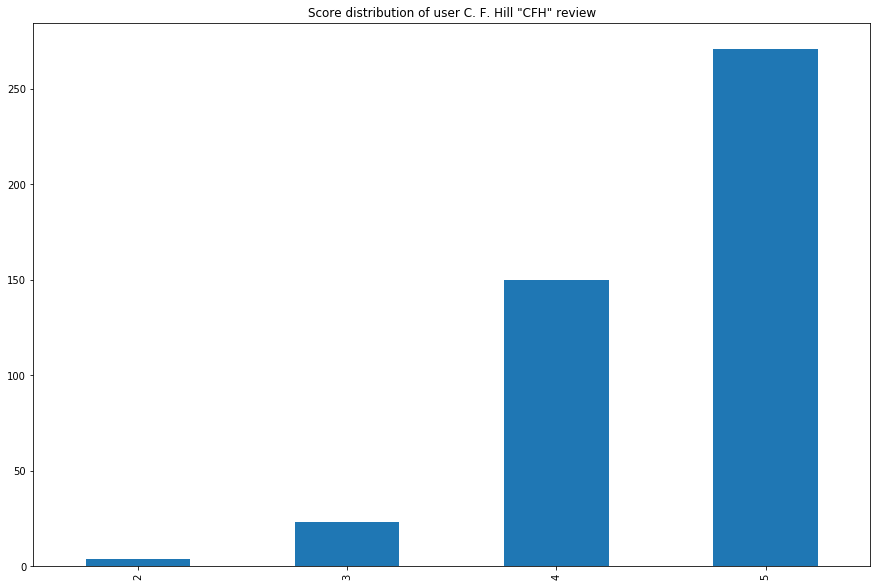

In [187]:
def plot_user(UserId):
    df_1user = odf[odf['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's dig into that:

In [188]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


A. Bennett seems a good target:

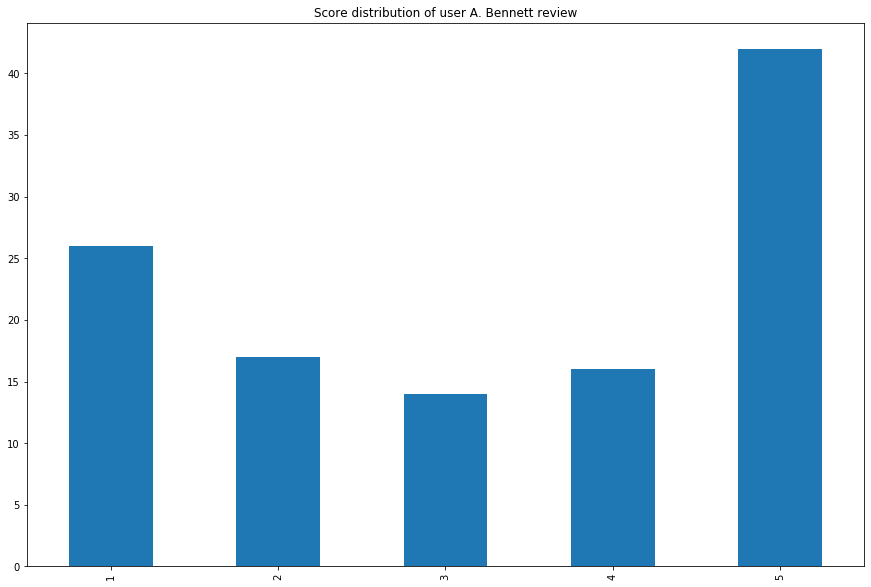

In [189]:
plot_user('A2M9D9BDHONV3Y')

He seems like a better analysis target! Now let's dig deep into his reviews:

In [190]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)


score 1 reviews most popular 2-gram / 3-gram:
   Count Occur %                   Phrase
0   11.0  42.31%             (never, buy)
1    9.0  34.62%           (buy, product)
2    8.0  30.77%    (never, buy, product)
3    8.0  30.77%  (monosodium, glutamate)
4    7.0  26.92%         (dry, tasteless)
5    7.0  26.92%            (decide, try)
6    7.0  26.92%          (picture, look)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %                Phrase
0     8.0  47.06%         (sauce, ruin)
1     8.0  47.06%         (ruin, whole)
2     8.0  47.06%  (sauce, ruin, whole)
3     7.0  41.18%           (give, try)
4     6.0  35.29%            (n't, buy)
5     6.0  35.29%       (product, ever)
6     5.0  29.41%            (n't, get)
7     5.0  29.41%         (taste, like)
8     5.0  29.41%          (get, wrong)
9     5.0  29.41%     (n't, get, wrong)
10    5.0  29.41%     (...., give, try)
11    5.0  29.41%          (...., give)
12    5.0  29.41%           (try, like)
13    5.0  2

Seems like A. Bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). He likes using the phrase "..." a lot as well. Sample size is very small though.

Let's look at full picture now instead of just one user:

In [205]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5547.0  10.61%   (taste, like)
1  2330.0   4.46%  (waste, money)
2  2175.0   4.16%    (could, n't)
3  2111.0   4.04%     (n't, even)
4  1809.0   3.46%     (n't, know)
5  1794.0   3.43%    (would, n't)
6  1645.0   3.15%      (n't, buy)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3161.0  10.62%   (taste, like)
1  1362.0   4.58%     (n't, like)
2  1304.0   4.38%    (would, n't)
3  1086.0   3.65%  (think, would)
4  1064.0   3.57%      (n't, buy)
5  1010.0   3.39%     (n't, know)
6   996.0   3.35%    (n't, taste)
7   945.0   3.17%    (could, n't)
8   912.0   3.06%   (taste, good)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3240.0    7.6%   (taste, like)
1  1632.0   3.83%    (would, n't)
2  1612.0   3.78%     (n't, like)
3  1557.0   3.65%   (taste, good)
4  1463.0   3.43%   (href=, http)
5  1406.0    3.3%     (n't, know)
6  1301.0   

Funny that people are more likely to attach HTML links (href=) for more positive reviews (3 and 4).
<br>
Other than that, not much useful discoveries except positive / negative tones, since people are very different in texting style. 
<br>
Maybe we should focus on popular single **adjective** word people used for different score. First we modify the function a bit for easier implementation:

In [206]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

Let's look at user A. Bennett again:

In [207]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
   Count Occur %     Phrase
0   13.0   50.0%        dry
1   12.0  46.15%     cheese
2   10.0  38.46%     little
3   10.0  38.46%        bad
4    8.0  30.77%       hard
5    8.0  30.77%      tasty
6    8.0  30.77%  expensive
7    8.0  30.77%  delicious
8    7.0  26.92%      bread
9    7.0  26.92%       poor
score 2 reviews most popular adjectives word:
   Count Occur %      Phrase
0   10.0  58.82%       whole
1    8.0  47.06%      cheese
2    6.0  35.29%       awful
3    6.0  35.29%       wrong
4    6.0  35.29%   delicious
5    5.0  29.41%        good
6    5.0  29.41%  particular
score 3 reviews most popular adjectives word:
   Count Occur %        Phrase
0    9.0  64.29%         whole
1    5.0  35.71%          high
2    4.0  28.57%          good
3    4.0  28.57%         great
4    4.0  28.57%  disappointed
5    4.0  28.57%         first
score 4 reviews most popular adjectives word:
   Count Occur %     Phrase
0    9.0  56.25%      great
1  

Obviously much more useful information here, e.g. A. Bennett hates food that are too dry and expensive
Let's also look at big picture:

In [208]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Count Occur %        Phrase
0   16224.0  31.04%          good
1   10804.0  20.67%           bad
2    4984.0   9.54%         great
3    4840.0   9.26%          much
4    4787.0   9.16%        little
5    4781.0   9.15%           old
6    4201.0   8.04%         first
7    3963.0   7.58%           new
8    3789.0   7.25%     different
9    3717.0   7.11%          many
10   3540.0   6.77%         small
11   3297.0   6.31%          real
12   2999.0   5.74%  disappointed
13   2889.0   5.53%          sure
14   2835.0   5.42%          free
15   2832.0   5.42%          diet
16   2769.0    5.3%          high
17   2659.0   5.09%          last
score 2 reviews most popular adjectives word:
      Count Occur %        Phrase
0   13548.0  45.51%          good
1    4252.0  14.28%          much
2    4198.0   14.1%           bad
3    3918.0  13.16%         great
4    3691.0   12.4%        little
5    2848.0   9.57%         small
6    2318.0   7.79%     